# Basic parallax survey simulation

The [tutorial on luminosity calibration](./Luminosity_Inference_DistPrior.ipynb) uses data from a simulated parallax survey. The code below shows an example of such a survey simulated with the code in [parallaxsurveys.py](./parallaxsurveys.py). It is assumed that the only data collected are the parallaxes and apparent magnitudes for a sample of stars that have a uniform space density distribution, with distances between the lower limit $r_\mathrm{L}$ and upper limit $r_\mathrm{H}$. The distribution of distances is thus
\begin{equation}
    r \sim \begin{cases}
        r^2 & r_\mathrm{L} \leq r \leq r_\mathrm{H} \\
        0 & \text{otherwise}
    \end{cases}\,,
\end{equation}

where $r_\mathrm{L}$ and $r_\mathrm{H}$ are the lower and upper limits on the distance. The implied distribution of true parallaxes $\varpi_\mathrm{true}$ is

\begin{equation}
    \varpi_\mathrm{true} \sim 
    \begin{cases}
    \varpi_\mathrm{true}^{-4} & \varpi_\mathrm{L}\leq 
    \varpi_\mathrm{true}\leq \varpi_\mathrm{H}\\
    0 & \text{otherwise}
    \end{cases}\,,
\end{equation}

where $\varpi_\mathrm{L}=1000/r_\mathrm{H}$ and $\varpi_\mathrm{H}=1000/r_\mathrm{L}$ are the lower and upper limits on the true parallax (where throughout this notebook units of pc are used for distance and milliarcsecond, mas, for parallax)\. The observed parallaxes $\varpi$ are distributed around the true values according to a normal distribution with standard deviation $\sigma_\varpi$:

\begin{equation}
    \varpi \sim {\cal N}(\varpi_\mathrm{true}, \sigma_\varpi)\,.
\end{equation}

The stars are all assumed to belong to the same luminosity class for which the absolute magnitudes have a Gaussian distribution with a standard deviation $\sigma_M$ around the mean $\mu_M$

\begin{equation}
    M_\mathrm{true} \sim {\cal N}(\mu_M, \sigma_M)\,.
\end{equation}

The true and observed apparent magnitudes ($m_\mathrm{true}$ and $m$) are

\begin{equation}
    m_\mathrm{true} =  M_\mathrm{true} + 5\log_{10} r - 5 = M_\mathrm{true} - 5\log_{10} \varpi_\mathrm{true} + 10 \quad\text{and}\quad 
    m \sim {\cal N}(m_\mathrm{true},\sigma_m)\,.
\end{equation}

In addition the survey is magnitude limited, meaning that no apparent magnitudes above $m_\mathrm{lim}$ appear in the observed sample.

The code below how to use the classes and funtions in [parallaxsurveys.py](./parallaxsurveys.py). The simulated survey is specified by: the number of stars $N_\mathrm{stars}$ located between the distance limits $r_\mathrm{L}$ and $r_\mathrm{H}$, the parameters of the absolute magnitude distribution, $\mu_M$ and $\sigma_M$, and the survey limit $m_\mathrm{lim}$. The number of observed stars, $N_\mathrm{survey}$, may thus be less than $N_\mathrm{stars}$. The default population and survey parameters correspond to TGAS measurements for a sample of red clump giants uniformly distributed in space between between 500 and 2850 pc.

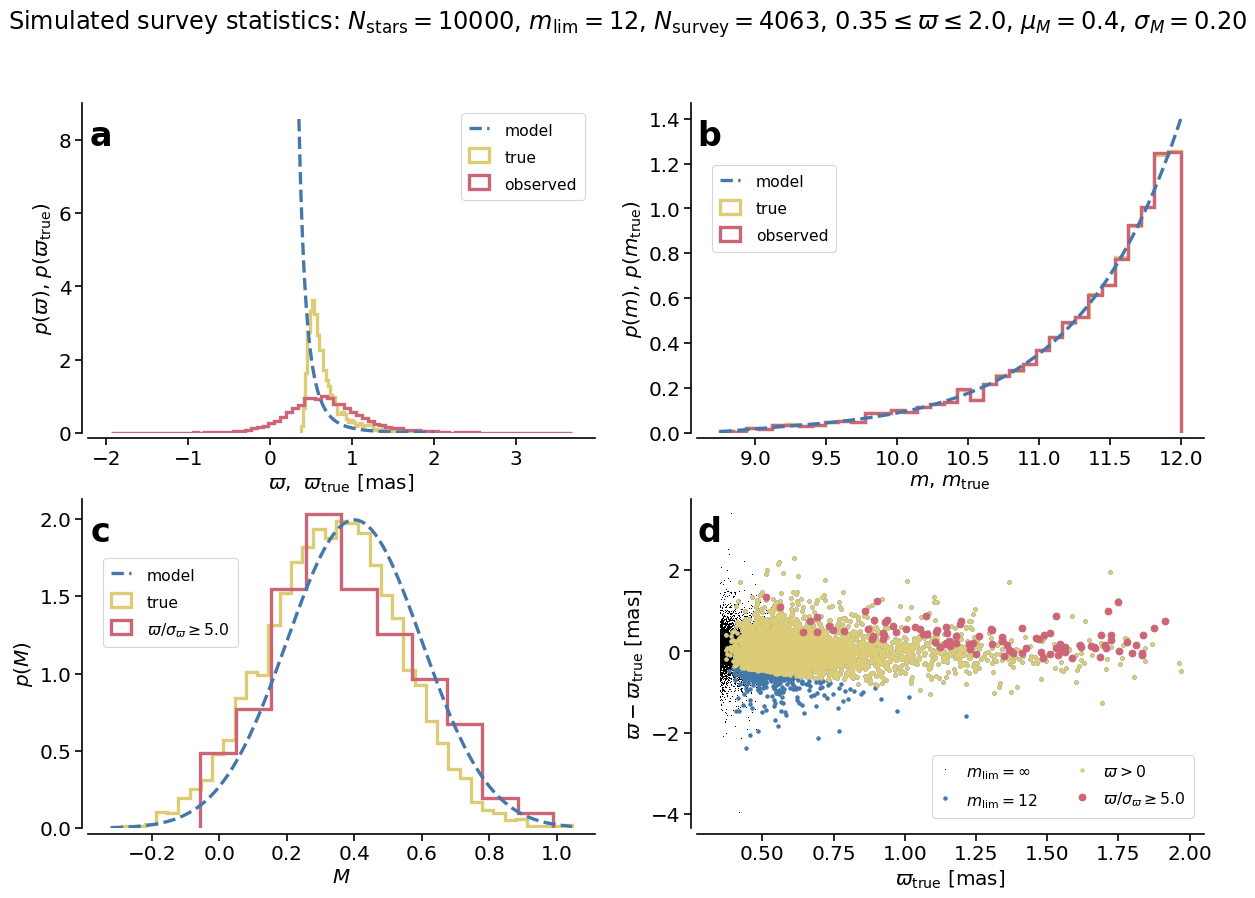

In [7]:
import numpy as np
import matplotlib.pylab as plt

from parallaxsurveys import UniformDistributionSingleLuminosityHip as udslH
from parallaxsurveys import UniformDistributionSingleLuminosityTGAS as udslT
from parallaxsurveys import showSurveyStatistics

distMin = 500.0
distMax = 1000.0/0.35
nStars = 10000
meanAbsMagTrue = 0.4
sigmaAbsMagTrue =  0.2
surveyseed = None
mlim = 12

# Hipparcos
#survey = udslH(nStars, distMin, distMax, meanAbsMagTrue, sigmaAbsMagTrue, surveyLimit=mlim)

# TGAS
survey = udslT(nStars, distMin, distMax, meanAbsMagTrue, sigmaAbsMagTrue, surveyLimit=mlim)

# Fix random seed
#survey.setRandomNumberSeed(53949896)

survey.generateObservations()
showSurveyStatistics(survey, usekde=False)

## Biases introduced by the survey limit and sample truncation

The survey limit and any further selection of stars, for example based on the relative parallax uncertainty, will lead to a set of stars that is not representative of the underlying population and this will cause systematic errors (biases) in the estimated value of $\mu_M$. This is demonstrated in the plot above.

The plot panels show the distribution of the true and observed parallaxes (__a__), the true and observed apparent magnitudes (__b__), the true absolute magnitudes and the distribution of the absolute magnitudes for stars with "good" parallaxes (__c__). In these three panels "model" refers to the underlying distribution from which the simulated true and observed quantities are generated. Panel __d__ shows the difference between the observed and true parallax as a function of the true parallax.

Panel __a__ shows how the true parallax distribution is different from the generating distribution because of the survey magnitude limit (leading to the exclusion stars too faint to enter the survey). This can also be appreciated in panel __d__ where the small black points are the stars that were not observed. Panel __a__ in addition shows the presence of a fraction of stars with negative measured parallaxes. These are perfectly legitimate measurement values and how they arise is explained in the [tutorial on negative parallaxes](./DemoNegativeParallax.ipynb).

Panels __c__ and __d__ show how the survey properties and a selection of stars with 'good parallaxes' leads to biases in the estimation of $\mu_M$. First, panel __c__ shows how the magnitude limit leads to a skewing of the distribution of the absolute magnitudes to brighter values because the intrisincally fainter stars have a higher probability of not making it into the survey. Panel __d__ shows how the magnitude limit does not skew the distribution of $\varpi-\varpi_\mathrm{true}$ but that a selection on positive and/or high precision parallaxes leads to a preference for stars for which the observed parallax is an overestimate of the true parallax. Hence the magnitude limit favours the brighter stars in the population, while selection of precise positive parallaxes leads to favouring the stars in the population for which the naively estimated value of the absolute magnitude ($M=m+5\log_{10}\varpi-10$) is fainter than the true value. These two biases may or may not compensate each other. This can be experimented with by changing the parameters of the survey or stellar population. For example a large value of $\sigma_M$ wil make the effect of the survey limit worse.

These biases can be accounted for in a Bayesian approach to the luminosity estimation problem, which moreover allows to make use of the information contained in the negative parallaxes. This is the topic of the [tutorial on luminosity calibration](./Luminosity_Inference_DistPrior.ipynb).

Panel __b__ above shows the distribution of the apparent magnitudes (true and observed) together with the underlying distribution from which the simulated true magnitudes were sampled. The latter distribution can be derived analytically, as shown below. The next section below also shows how one can predict the effect of the magnitude limit on the resulting distribution of absolute magnitudes, showing how the brighter part of the population is favoured.

## Expected distribution of $m_\mathrm{true}$

We will now derive the expected distribution of the true apparent magnitudes $p(m_\mathrm{true})$, first for the case of a complete survey ($m_\mathrm{lim}=\infty$). The apparent magnitude distribution derives from the distance distribution of the stars combined with the distribution of the stars over true absolute magnitude. So we first write down the full probability density for $r$:

\begin{equation}
    p(r) = \frac{3r^2}{A}\,, \quad\text{with}\quad A=r_\mathrm{H}^3 - r_\mathrm{L}^3\,,
\end{equation}

or in terms of $\varpi_\mathrm{true}$

\begin{equation}
    p(\varpi_\mathrm{true}) = \frac{3\varpi_\mathrm{true}^{-4}} {A'}\,, \quad\text{with}\quad
    A'=\varpi_\mathrm{L}^{-3} - \varpi_\mathrm{H}^{-3}\,.
\end{equation}

The apparent magnitude is $m_\mathrm{true} = M_\mathrm{true}+y$, where the variable $y=5\log_{10} r-5$ is the distance modulus, with $y_\mathrm{L} = 5\log_{10} r_\mathrm{L}-5 \leq y \leq 5\log_{10} r_\mathrm{H}-5 = y_\mathrm{H}$. The distribution of $y$ can be derived as:

\begin{equation}
    p(y) = p\left(r=10^{0.2(y+5)}\right) \times \left|\frac{dr}{dy}\right|
    = \frac{3\times10^{0.4(y+5)}}{A}\left(0.2\ln 10 \times 10^{0.2(y+5)}\right)
    = \frac{0.6\ln 10}{A} \times 10^{0.6(y+5)}\,.
\end{equation}

For the distribution of $m_\mathrm{true}$ for a fixed value of $M_\mathrm{true}$ we can then write (making use of $y=m_\mathrm{true}-M_\mathrm{true}$):

\begin{equation}
    p(m_\mathrm{true}\mid M_\mathrm{true}) = \frac{0.6\ln 10}{A} \times 10^{0.6(m_\mathrm{true}-M_\mathrm{true}+5)}\,,
\end{equation}

This is of course the well known "star count law" for stars uniformly distributed around the observer.

In the simulation above the value of $M_\mathrm{true}$ is not fixed but has a normal distribution around $\mu_M$. In fact at fixed distance modulus $y$, $m_\mathrm{true}$ is distributed as ${\cal N}(y+\mu_M, \sigma_M)$, which implies that the distribution $p(m_\mathrm{true})$ is given by the convolution of $p(y)$ and $p(M_\mathrm{true})$:

\begin{equation}
    p(m_\mathrm{true}) = \int_{y_\mathrm{L}}^{y_\mathrm{H}} p_y(y)p_{M_\mathrm{true}}(m_\mathrm{true}-y)\,dy =
    \int_{y_\mathrm{L}}^{y_\mathrm{H}} \frac{0.6\ln 10}{A} \times 10^{0.6(y+5)} \times
    \frac{1}{\sigma_M\sqrt{2\pi}} \exp\left(-\frac{1}{2}\left(\frac{m_\mathrm{true}-y-\mu_M}
    {\sigma_M}\right)^2\right)\,dy\,,
\end{equation}

which can be written as:

\begin{equation}
    p(m_\mathrm{true}) = \frac{0.6\ln 10}{A\sigma_M\sqrt{2\pi}} \int_{y_\mathrm{L}}^{y_\mathrm{H}}
    \exp\left(0.6\ln 10(y+5)\right) \exp\left(-\frac{1}{2}\left(\frac{m_\mathrm{true}-y-\mu_M}
    {\sigma_M}\right)^2\right)\,dy\,.
\end{equation}

By introducing the quantities $B=m_\mathrm{true}-\mu_M$ and $C=0.6\ln10$, the terms in the exponent of $e$ in the integral can be written as:

\begin{equation}
    -\frac{1}{2}\left(\frac{y-B}{\sigma_M}\right)^2 + C(y+5)\,.
\end{equation}

This expression can (after some basic manipulation) be written as:

\begin{equation}
    -\frac{1}{2}\left(\frac{y-(B+C\sigma_M^2)}{\sigma_M}\right)^2 + BC + \frac{1}{2}C^2\sigma_M^2 + 5C\,,
\end{equation}

which separates out the constant terms in the integral from those involving $y$:

\begin{equation}
    p(m_\mathrm{true}) = \frac{C}{A} \exp\left(C(B+C\sigma_M^2/2+5)\right) 
    \int_{y_\mathrm{L}}^{y_\mathrm{H}} \frac{1}{\sigma_M\sqrt{2\pi}} 
    \exp\left(-\frac{1}{2}\left(\frac{y-(B+C\sigma_M^2)}{\sigma_M}\right)^2\right)\,dy
\end{equation}

The integral can be worked out in terms of the error function:
\begin{equation}
    \mathrm{erf}(z) = \int_0^z \frac{2}{\sqrt{\pi}} e^{-t^2}\,dt\,.
\end{equation}

This leads to:

\begin{equation}
    p(m_\mathrm{true}) = \frac{C}{A} \exp\left(C(B+C\sigma_M^2/2+5)\right) \frac{1}{2}
    \left(\mathrm{erf}\left(\frac{y_\mathrm{H}-(B+C\sigma_M^2)}{\sigma_M\sqrt{2}}\right) -
    \mathrm{erf}\left(\frac{y_\mathrm{L}-(B+C\sigma_M^2)}{\sigma_M\sqrt{2}}\right) \right)
\end{equation}

The following code block generates an example of what this distribution looks like for a survey defined in the above code block, but with $m_\mathrm{lim}=\infty$. For a finite value of $m_\mathrm{lim}$ the functional form for $p(m_\mathrm{true})$ will be cut-off at $m_\mathrm{lim}$. The probability distribution then has to be renormalized by numerical integration. This truncated form is only an approximation as in reality (and in the survey simulation above) the truncation is done on the _observed_ value $m$, which includes an error and this introduces a certain fuziness in the cut-off of $m_\mathrm{true}$. This 'fuziness' will depend on the details of the survey.

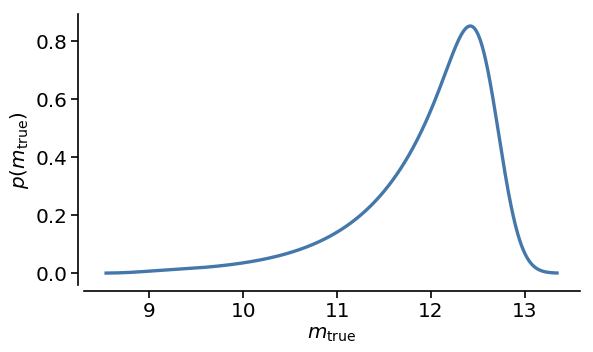

In [16]:
from plotstyles import useagab, apply_tufte

survey = udslT(nStars, distMin, distMax, meanAbsMagTrue, sigmaAbsMagTrue, surveyLimit=np.inf)
survey.generateObservations()

useagab(usetex=False, fontfam='sans')
fig, ax = plt.subplots(1, 1, figsize=(8,4.5))
apply_tufte(ax)

m = np.linspace(survey.observedMagnitudes.min(), survey.observedMagnitudes.max(), 1000)
ax.plot(m, np.exp(survey.apparentMagnitude_lpdf(m)), '-', lw=3)
ax.set_xlabel(r'$m_\mathrm{true}$')
ax.set_ylabel(r'$p(m_\mathrm{true})$')

plt.show()

## Expected distributions of $r$ and $M_\mathrm{true}$ in the presence of a survey limit

In the simulated survey above the joint distribution of $r$ and $M_\mathrm{true}$ is given by

\begin{equation}
    p(r,M_\mathrm{true}) = \frac{3r^2}{A}{\cal N}(M_\mathrm{true}\mid \mu_M,\sigma_M)\,,
\end{equation}

where $A=r^3_\mathrm{H}-r^3_\mathrm{L}$, and the distribution is normalized in the absence of a survey limit. If there is a survey limit $m_\mathrm{lim}$ the following holds

\begin{equation}
    M_\mathrm{true}+5\log_{10} r-5\leq m_\mathrm{lim}\,,
\end{equation}

where again the details of how the survey cut-off is realized in practice are ignored (see above). This relation allows one to obtain the marginal distributions for $r$ and $M_\mathrm{true}$

\begin{equation}
    p(r) \propto \int_{-\infty}^{m_\mathrm{lim}-5\log_{10} r+5} p(r,M_\mathrm{true})\,dM_\mathrm{true} =
    \frac{3r^2}{A}\Phi\left(\frac{m_\mathrm{lim}-(\mu_M+5\log_{10} r-5)}{\sigma_M}\right)\,,
\end{equation}

\begin{equation}
    p(M_\mathrm{true}) \propto \int_{r_\mathrm{L}}^{r_\mathrm{lim}} p(r,M_\mathrm{true})\,dr = {\cal N}(M_\mathrm{true}\mid \mu_M,\sigma_M)\times
    \frac{r^3_\mathrm{lim}-r^3_\mathrm{L}}{A}\,,
\end{equation}

where $r_\mathrm{lim} = \mathrm{min}(r_\mathrm{H}, 10^{0.2(m_\mathrm{lim}-M_\mathrm{true}+5)})$.
The marginal distributions can be normalized numerically. The function $\Phi(t)$ is the cumulative standard normal distribution:

\begin{equation}
    \Phi(t) = \int_{-\infty}^t \frac{1}{\sqrt{2\pi}} e^{-z^2/2}\,dz\,.
\end{equation}

The code block below shows the distributions of $r$ and $M_\mathrm{true}$ for several choices of stellar population parameters. Note how the mean of $M_\mathrm{true}$ shifts to values smaller than $\mu_M$ as $\sigma_m$ increases. This is due to increasingly favouring the brighter stars in the population when applying a mangnitude cut-off. The bottom panels show the value of $\langle M_\mathrm{true}\rangle-\mu_M$ as a function of $\sigma_M$ and $m_\mathrm{lim}$. The latter two panels in fact show a variant of the 'Malmquist bias' which occurs for magnitude limited surveys. In this case because there is an upper limit on $r$ the bias also depends on $m_\mathrm{lim}$. If there is no limit on $r$ the dependence of the bias on $m_\mathrm{lim}$ is very weak. I the case $r_\mathrm{L}=0$ and $r_\mathrm{H}=+\infty$ there is strictly no dependence of the bias on $m_\mathrm{lim}$ and then the bias (for a uniform space density of stars, as assumed throughout this notebook) is $\langle M_\mathrm{true}\rangle-\mu_M=-1.382\sigma_M^2$.

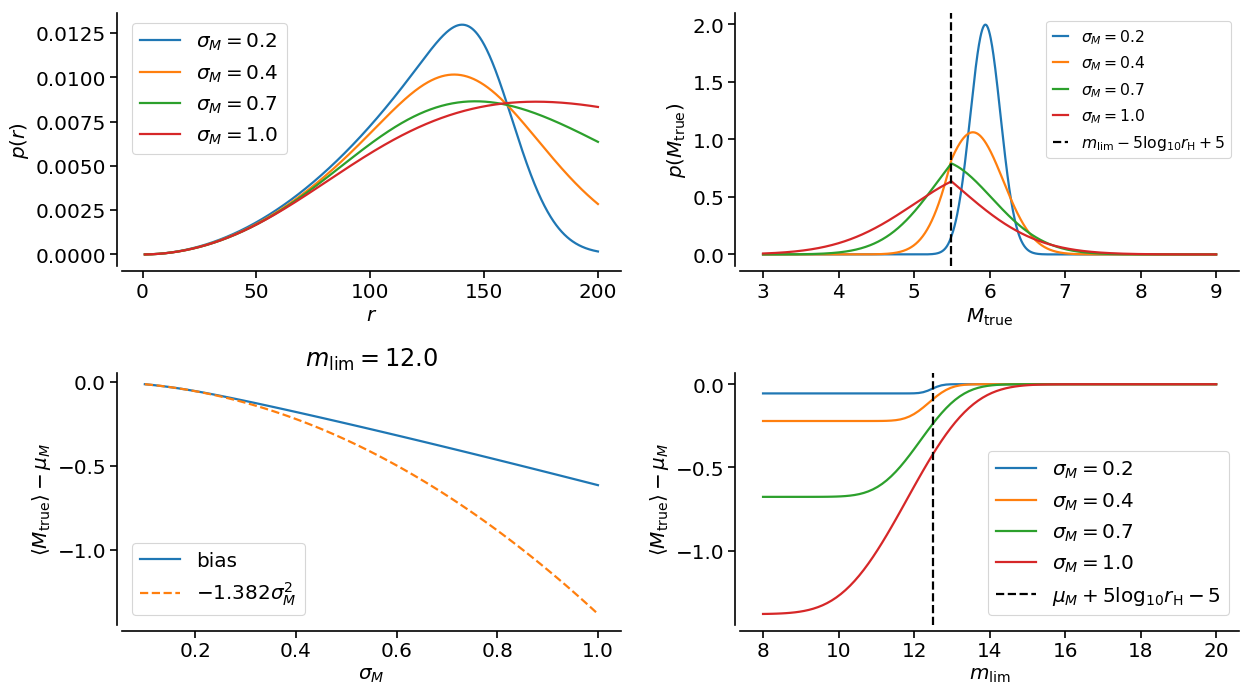

In [21]:
from scipy.stats import norm
from scipy.integrate import simps
from plotstyles import useagab, apply_tufte
from parallaxsurveys import marginal_pdf_distance, marginal_pdf_absMag

rmin = 1.0
rmax = 200.0
mu = 6.0
sigma = np.array([0.2, 0.4, 0.7, 1])
mlim = 12.0

r = np.linspace(rmin,rmax,1000)
M = np.linspace(mu-3*sigma.max(), mu+3*sigma.max(), 1000)

useagab(usetex=False, fontfam='sans', sroncolours=False)
fig, ((axA, axB), (axC, axD)) = plt.subplots(2, 2, figsize=(16,9))

apply_tufte(axA)
for s in sigma:
    axA.plot(r, marginal_pdf_distance(r,rmin,rmax,mu,s,mlim), label=r'$\sigma_M={0:.1f}$'.format(s))
axA.set_xlabel('$r$')
axA.set_ylabel('$p(r)$')
axA.legend()

apply_tufte(axB)
for s in sigma:
    axB.plot(M, marginal_pdf_absMag(M,rmin,rmax,mu,s,mlim), label=r'$\sigma_M={0:.1f}$'.format(s))
axB.axvline(x=mlim-5*np.log10(rmax)+5, color='k', ls='--', label='$m_\mathrm{lim}-5\log_{10} r_\mathrm{H}+5$')
axB.set_xlabel('$M_\mathrm{true}$')
axB.set_ylabel('$p(M_\mathrm{true})$')
axB.legend(fontsize=14, handlelength=1)

bias = []
M=np.linspace(mu-5, mu+5, 1000)
ss = np.linspace(0.1, 1, 100)
for s in ss:
    bias.append(simps(M*marginal_pdf_absMag(M,rmin,rmax,mu,s,mlim), M)-mu)
apply_tufte(axC)
axC.plot(ss, bias, label='bias')
axC.plot(ss,-1.382*ss*ss,'--', label='$-1.382\sigma_M^2$')
axC.set_xlabel(r'$\sigma_M$')
axC.set_ylabel(r'$\langle M_\mathrm{true}\rangle-\mu_M$')
axC.set_title(r'$m_\mathrm{{lim}}={0:.1f}$'.format(mlim))
axC.legend()

mm = np.linspace(8, 20, 100)
apply_tufte(axD)
for s in sigma:
    bias = []
    for m in mm:
        bias.append(simps(M*marginal_pdf_absMag(M,rmin,rmax,mu,s,m), M)-mu)
    axD.plot(mm, bias, label=r'$\sigma_M={0:.1f}$'.format(s))
axD.set_xlabel(r'$m_\mathrm{lim}$')
axD.set_ylabel(r'$\langle M_\mathrm{true}\rangle-\mu_M$')
axD.axvline(x=mu+5*np.log10(rmax)-5, color='k', ls='--', label='$\mu_M+5\log_{10} r_\mathrm{H}-5$')
axD.legend()

plt.tight_layout()
plt.show()